In [51]:
import pickle
import numpy as np
import scipy.sparse as ss
import datetime

#### IMPORT DATA ####

data_source = 'TrainSet2014_3.pkl'
#data_source = 'CompetitionSet2017_3.pkl'

full_dynamic_graph_sparse, unconnected_vertex_pairs, year_start, years_delta = pickle.load(open( data_source, "rb" ) )

NUM_OF_VERTICES = 64719 # number of vertices of the semantic net
NUM_OF_EDGES    = full_dynamic_graph_sparse[:, 0].size

#### BUILD ADJACENCY ####

# The concatenation is used to produce a symmetric adjacency matrix
data_rows = np.concatenate([full_dynamic_graph_sparse[:, 0], full_dynamic_graph_sparse[:, 1]])
data_cols = np.concatenate([full_dynamic_graph_sparse[:, 1], full_dynamic_graph_sparse[:, 0]])
data_ones = np.ones(len(data_rows), np.uint32)

adjM = ss.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

#### BUILD DEGREE VECTOR ####

degree_vec = np.asarray(adjM.sum(1)).flatten()

print("Imported", data_source)
print("\nBuilt adjacency matrix with:")
print(" - ", NUM_OF_VERTICES, " vertices")
print(" - ", NUM_OF_EDGES, " edges\n")
print("Found ", np.count_nonzero(degree_vec == 0)," unconnected nodes.")

Imported TrainSet2014_3.pkl

Built adjacency matrix with:
 -  64719  vertices
 -  2278611  edges

Found  27230  unconnected nodes.


# Analyzing the links to be predicted

In [52]:
pred_degree0 = degree_vec[unconnected_vertex_pairs[:,0]]
pred_degree1 = degree_vec[unconnected_vertex_pairs[:,1]]

# Counts how many links between two nodes with k = 0:
k0 = np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between one nodes with k = 0 and one k > 0:
k1 = np.count_nonzero(pred_degree0 * pred_degree1 == 0) - np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between two nodes with k > 0:
k2 = np.count_nonzero((pred_degree0 * pred_degree1) > 0)

print("Out of 1.000.000 new links:")
print(k0," are between two vertices with k = 0 -> ordered randomly;")
print(k1," are between one vertex with k = 0 and one with k > 0 -> ordered by preferential attachment;")
print(k2," are between two vertices with k > 0 -> ordered by network based predictions;")

Out of 1.000.000 new links:
265966  are between two vertices with k = 0 -> ordered randomly;
500060  are between one vertex with k = 0 and one with k > 0 -> ordered by preferential attachment;
233974  are between two vertices with k > 0 -> ordered by network based predictions;


# Simple PA

In [82]:
def simple_pa(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns an ordered list of those pairs by their index
    # running from 0 to 999.999
    
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    
    pred_degree0 = degree_vec[links_to_score[:,0]]
    pred_degree1 = degree_vec[links_to_score[:,1]]
    
    score_list = []
    
    for item in unconnected_vertex_pairs:
        #if degree_vec[item[0]] == 0 or degree_vec[item[1]] == 0:
        score_list.append(degree_vec[item[0]] + degree_vec[item[1]])
        #else:
        #    score_list.append(0)
        
    sorted_predictions = np.argsort(-1.0*np.array(score_list))
    
    return sorted_predictions

In [83]:
print(datetime.datetime.now().time())

print("Computing Simple PA...")

sorted_predictions = simple_pa(adjM, unconnected_vertex_pairs)

print("Done!")

print(datetime.datetime.now().time())

12:29:40.837189
Computing Simple PA...
Done!
12:29:41.873240


# AUC (for 2014 -> 2017 predictions)

In [84]:
import matplotlib.pyplot as plt

def calculate_ROC(data_vertex_pairs, data_solution, show_plot = False):
    data_solution = np.array(data_solution)
    data_vertex_pairs_sorted = data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    
    if show_plot == True:
        plt.plot(xpos, ypos)
        plt.show()
    
    AUC = sum(ROC_vals)/len(ROC_vals)
    return AUC

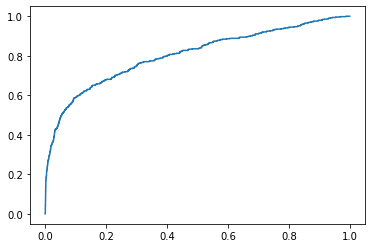

Area Under Curve for Evaluation:  0.8038421610708972


In [85]:
with open('TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)
    
AUC = calculate_ROC(sorted_predictions, np.array(unconnected_vertex_pairs_solution), True)

print('Area Under Curve for Evaluation: ', AUC)


# Exporting a submission file (for 2017 data)

In [55]:
import json

# Save the results for submission.
submit_file = "bacalhau_com_todos.json"

all_idx_list_float=list(map(float, sorted_predictions))
with open(submit_file, "w", encoding="utf8") as json_file:
    json.dump(all_idx_list_float, json_file)
    
print("Solution stored as "+submit_file+".\nLooking forward to your submission.")

Solution stored as bacalhau_com_todos.json.
Looking forward to your submission.
